In [1]:
import sys
print(sys.path)

['/dli/task/ComParE2022_VecNet/notebooks/DK', '/opt/conda/lib/python38.zip', '/opt/conda/lib/python3.8', '/opt/conda/lib/python3.8/lib-dynload', '', '/opt/conda/lib/python3.8/site-packages', '/opt/conda/lib/python3.8/site-packages/IPython/extensions', '/root/.ipython']


In [2]:
import os
import pandas as pd
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import config ,config_pytorch
#from evaluate import get_results
import numpy as np

# Troubleshooting and visualisation
# import IPython.display as ipd

# humbug lib imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#from PyTorch import config_pytorch
from datetime import datetime
import math
import pickle

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
from datetime import datetime
import time

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import sys

from tqdm.notebook import tqdm
# additional pytorch tools
import random
import torchaudio
import torchaudio.transforms as AT
import torchvision.transforms as VT
from torch.cuda.amp import autocast, GradScaler
from timm.scheduler.cosine_lr import CosineLRScheduler
import timm
import timm.optim
from timm.loss import BinaryCrossEntropy
from timm.utils import NativeScaler
from timm.models import model_parameters
from glob import glob
## nnAudio
from nnAudio import features , Spectrogram
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import argparse



/opt/conda/lib/python3.8/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [3]:
#parser = argparse.ArgumentParser(description='Trainable_SpecAugment', formatter_class=argparse.ArgumentDefaultsHelpFormatter)
batch_size = 8
num_workers= 4
pin_memory = True
test_batch_size = 8
DEBUG = False
num_epochs= 200              
USE_SHORT_AUDIO = True
                    

In [4]:
classes = ['an arabiensis','culex pipiens complex', 'ae aegypti','an funestus ss','an squamosus',
               'an coustani','ma uniformis','ma africanus' ]

In [5]:
def get_offsets_df(df, short_audio=False):
    audio_offsets = []
    #This is same as defined in config -min_duration = win_size * frame_duration
    min_length = config.win_size*config.NFFT/(((1/config.n_hop)*config.NFFT)*config.rate)
    step_frac = config.step_size/config.win_size
    stride = step_frac*min_length
#     print("min_length = " +str(min_length))
#     print("step_frac = " +str(step_frac))
#     print("stride = " +str(stride))
    for _,row in df.iterrows():
        #processed_data keeps track of the tensor_values processed thus far
        if row['length'] > min_length:
            processed_data = 0
            #total_data is the total tensor present in the audio
            total_data = config.rate*row['length']
            #print("********")
            count = 0
            #print("count = " +str(count))
            #print("id = " + str(row['id']) + " duration = " +str(row['length']) + "total x vals = " + str(total_data))
            inner_loop_flag = False
            #print("going into the inner loop to offset....")
            while(processed_data < total_data):
                #print("inside inner loop.....")
                start = count*stride*config.rate
                #now find out the row_len
                if total_data - (start + min_length*config.rate) >= 0:
                    #print("full chunk ")
                    row_len = min_length
                    end = start + row_len*config.rate
                    audio_offsets.append({'id':row['id'], 'offset':count, 'length': row_len,'specie_ind': row['specie_ind'],'start':start,'end':end})
                    #print("count = " +str(count) + "offset = " +str(count) + "start = " +str(start) + "end = " +str(end))
                    #print("for count.... = " + str(count) + "processed data = " +str(processed_data))
                    count+=1
                    processed_data = (count*stride)*config.rate
                    
                else:
                    inner_loop_flag = True
                    break
                    
                                                       
            #for processing residual data
            if(inner_loop_flag):
                #print("processing residual ....processed " +str(processed_data) + " of " + str(total_data))
                start = count*stride*config.rate
                resid_durn = round((total_data - processed_data)/config.rate,2)
                end = total_data
                #print("for..." + str(row['id']) + " adding the residual data in the data frame with duration = " + str(resid_durn))
                audio_offsets.append({'id':row['id'], 'offset':count, 'length':resid_durn ,'specie_ind': row['specie_ind'],'start':start,'end':end})
            
        elif short_audio:
            start = 0
            end = row['length']*config.rate
            audio_offsets.append({'id':row['id'], 'offset':0,'length': row['length'],'specie_ind': row['specie_ind'],'start':0 , 'end':end})
    return pd.DataFrame(audio_offsets)       


In [6]:

# ####### Prepare df######

def prepare_df(classes ,csv_loc = config.data_df  ):
    """This function reads a csv and creates a dataframe for further processing."""
    df = pd.read_csv(csv_loc)
    #df = df.loc[df['Grade'].notnull()]
    df = df.loc[df['species'].notnull()]
    # a new column for specie_index to hold numerical values for specie
    df['specie_ind'] = "NULL_VAL"
    ind = 0
    for specie in classes:
        print("specie = " + str(specie) + "and its index = " + str(ind) )
        row_indexes=df[df['species']==specie].index 
        df.loc[row_indexes,'specie_ind']= ind
        ind+=1
    #remove all the rows where specie is other than the one present in classes
    df.drop(df[df['specie_ind'] == "NULL_VAL"].index, inplace=True)
    #filter the data for TZ and cup recordings only
    idx_multiclass = np.logical_and(df['country'] == 'Tanzania', df['location_type'] == 'cup')
    df_all = df[idx_multiclass]
    df_all.reset_index(inplace=True, drop = True )
    return df_all


In [7]:
#### plt df
def plot_df(df):
    fig, ax = plt.subplots(figsize=(8, 6))
    import seaborn as sns
    sns.countplot(x = 'species', data = df , ax = ax , hue = 'gender',palette='dark')
    #ax.bar_label(ax.containers[0])
    #ax.bar_label(ax.containers[-1], fmt='Count:\n%.2f', label_type='center')
    plt.xticks(rotation=90 )
    plt.title("Distribution of Species ")
    plt.rc('xtick', labelsize=12)
    plt.rc('xtick', labelsize=12)
    plt.rc('axes', labelsize=15)
    plt.rc('figure', titlesize=15)
    plt.show

In [8]:
### Train _test split####
def train_test_split(df_all):
    np.random.seed(42)
    msk_test = np.random.rand(len(df_all)) < 0.2
    df_test = df_all[msk_test]
    df_train_temp  = df_all[~msk_test]
    msk_train = np.random.rand(len(df_train_temp)) < 0.2
    df_val = df_train_temp[msk_train]
    df_train  = df_train_temp[~msk_train]
    return df_train ,df_val ,df_test

In [9]:
### Validate split ####
def validate_split(df1 , df2):
    df_temp = pd.merge(df1,df2, on = 'id', how = 'inner')
    #print(df_temp)
    common_elem = len(df_temp)
    #print("common_elem = ",common_elem)
    con = (common_elem == 0)
    #print("condition = ",con)
    assert (con), "Split has issues"
    print("split is a success")


In [10]:

### Specie _distribution ###
def get_specie_distri(df , classes , type_df = None):
    """This function takes a dataframe and provides a count of each specie class"""
    for i in range(len(classes)):
        print("DF type = " + str(type_df))
        df_temp = df[df['specie_ind'] == i]
        print("i = " +str(i))
        print(len(df_temp))


In [11]:
## Class weights to address imbalance in classes ###
def get_class_weights(df):
    np.array(df_train_offset.specie_ind)
    from sklearn.utils import class_weight
    class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(np.array(df.specie_ind)),y=np.array(np.array(df.specie_ind)))
    print(type(class_weights))
    print(class_weights.shape)
    return class_weights

In [12]:
### Pad_mean #####
# This function pads a short-audio tensor with its mean to ensure that it becomes a 1.92 sec long audio equivalent
def pad_mean(x_temp,rate = config.rate, min_length = config.min_duration ):
    if DEBUG:
        print("inside padding mean...")
    x_mean = torch.mean(x_temp)
    #x_mean.cuda()
    
    if DEBUG:
        print("X_mean = " + str(x_mean))
    left_pad_amt = int((rate*min_length-x_temp.shape[1])//2)
    if DEBUG:
        print("left_pad_amt = " + str(left_pad_amt))
    left_pad = torch.zeros(1,left_pad_amt) #+ (0.1**0.5)*torch.randn(1, left_pad_amt)
    if DEBUG:
        print("left_pad shape = " + str(left_pad.shape))
    left_pad_mean_add = left_pad + x_mean
    if DEBUG:
        print("left_pad_mean shape = " + str(left_pad_mean_add))
        print("sum of left pad mean add = " + str(torch.sum(left_pad_mean_add)))
    
    right_pad_amt = int(rate*min_length-x_temp.shape[1]-left_pad_amt)
    right_pad = torch.zeros(1,right_pad_amt)# + (0.1**0.5)*torch.randn(1, right_pad_amt)
    if DEBUG:
        print("right_pad shape = " + str(right_pad.shape))
    right_pad_mean_add = right_pad + x_mean
    if DEBUG:
        print("right_pad_mean shape = " + str(right_pad_mean_add))
        print("sum of right pad mean add = "  + str(torch.sum(right_pad_mean_add)))
    
    
    
    f = torch.cat([left_pad,x_temp,right_pad],dim=1)[0]
    f = f.unsqueeze(dim = 0)
    #print("returning a tensor of shape = " + str(f.shape))
    return(f)


In [13]:
### Plot confusion Matrix ######
def plot_confusion_matrix(y_hat,y_true,classes):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_hat, y_true ,labels= range(len(classes)))
    import seaborn as sns
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cellsplt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(classes, fontsize = 10)
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90)
    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(classes, fontsize = 10)
    plt.yticks(rotation=0)
    plt.show()

In [14]:
class Normalize_batch(nn.Module):
    def __init__(self):
        super(Normalize_batch, self).__init__()
        
    def forward(self, x):
        batch_mean = torch.mean(x, dim=0, keepdim=True)
        batch_std = torch.std(x, dim=0, keepdim=True)
        epsilon = 1e-8
        batch_std = torch.sqrt(batch_std ** 2 + epsilon)
        batch_normalized = (x - batch_mean) / batch_std
        return batch_normalized


In [15]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [16]:
class MyModel(nn.Module):
    def __init__(self, model_name, image_size = 224):
        super().__init__()
        # num_classes=0 removes the pretrained head
        self.backbone = timm.create_model(model_name,
                        pretrained=True, num_classes=8, in_chans=1, 
                        drop_path_rate=0.2, global_pool='max',
                        drop_rate=0.25)
        #####  This section is model specific
        #### It freezes some fo the layers by name
        #### you'll have to inspect the model to see the names
                #### end layer freezing
        self.out = nn.Linear(self.backbone.num_features, 1)
        self.sizer = VT.Resize((image_size,image_size),antialias = True)
        self.spec_layer = features.STFT(n_fft=int(config.NFFT), freq_bins=None, hop_length=int(config.n_hop),
                              window='hann', freq_scale='linear', center=True, pad_mode='reflect',
                           sr=config.rate, output_format="Magnitude", trainable=False,verbose = False).to('cuda')
        self.batch_norm = nn.BatchNorm2d(num_features= 1)
        #self.augment_layer = augment_audio(trainable = True, sample_rate = config.rate)
        
    def forward(self, x,train = True):
        # first compute spectrogram
        spec_gram = self.spec_layer(x)
        output = {}
        #print("post spec gram shape = ",spec_gram.shape)
        spec_gram = self.batch_norm(spec_gram.unsqueeze(dim = 1))
        #print("post norm shape = ",spec_gram.shape)
        spec_gram_nan_check = torch.isnan(spec_gram).any().item()
        assert not (spec_gram_nan_check) ,"Tensor contains NaN values after spec gram creation."
        
        with torch.no_grad():
            if train == True:
                #generate a random number and if condition is met apply aug
                ta_transformations_rndm_choice = VT.RandomChoice([AT.FrequencyMasking(freq_mask_param=100),AT.TimeMasking(time_mask_param=50)], p=[.4, .4])
                ta_transformations_rndm_apply = VT.RandomApply([AT.FrequencyMasking(freq_mask_param=50),AT.TimeMasking(time_mask_param=25)],p = .15)
                spec_gram = ta_transformations_rndm_choice(spec_gram)
                spec_gram = ta_transformations_rndm_apply(spec_gram)
                spec_gram_nan_check = torch.isnan(spec_gram).any().item()
                assert not (spec_gram_nan_check) ,"Tensor contains NaN values after augmentations  "
                aug_bat = [ta_transformations_rndm_choice(spec_gram),ta_transformations_rndm_apply(spec_gram)]
                output['feat'] = aug_bat
                
        x = self.sizer(spec_gram.squeeze(dim = 1))
        #print("post sizer shape = ",x.shape)
        x = x.unsqueeze(dim = 1)
        #print("post unsqueeze shape = ",x.shape)
        
        # then repeat channels
        del spec_gram,spec_gram_nan_check
        if DEBUG:
            print("Final shape that goes to backbone = " + str(x.shape))
                
        x = self.backbone(x)
        backbone_op_nan_check = torch.isnan(x).any().item()
        assert not (backbone_op_nan_check) ,"Tensor contains NaN values in the backbone OP "
        #print("x shape = " + str(x.shape))
        #print("x = " +str(x))
        #pred = nn.Softmax(x)
        pred = x
        #print(np.argmax(pred.detach().cpu().numpy()))
        #print(pred)
        output["prediction"]=  pred 
        #print(output)
        del x , backbone_op_nan_check
        return output


In [17]:

### Test Model####
def test_model(model, loader, criterion,  classes = classes,device=None , call = "val"):
    softmax = nn.Softmax()
    if DEBUG:
        print("calling for ..." +str(call))
    with torch.no_grad():
        if device is None:
            torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        sigmoid = nn.Sigmoid()
        test_loss = 0.0
        model.eval()
        if DEBUG:
            print("inside test....")
        all_y = []
        all_y_pred = []
        counter = 1
        if DEBUG:
            print("length of loader = " + str(len(loader)))
        for idx,(x,y) in enumerate(loader):
            if DEBUG:
                print("loader index = " + str(idx))
                            
            x = x.to(device).float() 
            y = y.type(torch.LongTensor).to(device)
            if DEBUG:
                print("y = " + str(y))
            y_pred = model(x,train = False)['prediction']
            #y_pred_smax = softmax(y_pred)
            preds = torch.argmax(y_pred, axis = 1)
            y_pred_cpu = y_pred.cpu().detach()
            if DEBUG:
                print("y_pred_cpu = " + str(y_pred_cpu))
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("preds = " +str(preds))
            all_y_pred.append(preds.cpu().detach())
                                   
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            all_y.append(y.cpu().detach())
            #all_y_pred.append(np.argmax(y_pred.cpu().detach().numpy()))
            
            del x
            del y
            del y_pred
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("inside test....")
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        test_loss = test_loss/len(test_loader)
        test_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
    
    
    return test_loss, test_f1 , all_y,all_y_pred


In [18]:
def train_model(train_loader, val_loader,test_loader, model ,classes,class_weights,num_epochs,encoder ):
    # Creates a GradScaler once at the beginning of training.
    torch.manual_seed(0)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'Training on {device}')    
    
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))

    model = model.to(device)
    weights_adj = torch.tensor(class_weights).type(torch.float).to(device)
    #criterion_1 = nn.CrossEntropyLoss(weight=weights_adj,label_smoothing=.1)
    #criterion_2 = nn.CrossEntropyLoss(weight=weights_adj)
    criterion = SupConLoss(temperature= .07).to(device)
    lr = .000015
    base_optimiser = timm.optim.AdamP(model.parameters(), lr= lr)
    look_optimiser = timm.optim.Lookahead(base_optimiser)
    cooldown_epoch = 50
    
    #optimiser = timm.optim.AdamW(model.parameters(), lr=config_pytorch.lr)
    #timm.optim.Lookahead(optimiser, alpha=0.5, k=6)
    scheduler = timm.scheduler.CosineLRScheduler(base_optimiser, t_initial= num_epochs,lr_min= lr/100,warmup_t = 5,warmup_lr_init= lr/10,noise_std=.075)
    
    
    #optimiser = timm.optim.RAdam(model.parameters(), lr=config_pytorch.lr/10)
    num_epochs = num_epochs
    all_train_loss = []
    all_train_f1 = []
    all_val_loss = []
    all_val_f1 = []
    best_val_loss = np.inf
    best_val_f1 = -np.inf
    best_train_f1 = -np.inf
    best_epoch = -1
    checkpoint_name = None
    overrun_counter = 0
    sigmoid = nn.Sigmoid()
    softmax = nn.Softmax()
    all_train_f1 = []
    all_val_f1 = []
    accumulation_steps = 4
    lr_log = []
    for e in range(num_epochs + cooldown_epoch):
        start_time = time.time()
        train_loss = 0.0
        model.train()
        running_loss = 0.0
        all_y = []
        all_y_pred = []
        #tk0 = tqdm(train_loader, total=int(len(train_loader)))
        for batch_i, inputs in enumerate(train_loader):
            if DEBUG:
                print("inside train loop.. batch_ind = " +str(batch_i))
            if batch_i % 1000 == 0:
                bat_time = time.time()
                durn = (bat_time - start_time)/60
                print("epoch = " +str(e) + "batch = " +str(batch_i) + " of " + str(len(train_loader)) + "duraation = " + str(durn))
            x = inputs[0].to(device).float()
            if DEBUG:
                print("inside train loop.. x device = " +str(x.device))
                
            
            y = inputs[1].type(torch.LongTensor).to(device)
            x_sum = torch.sum(x,axis = 1)
            x_sum.unsqueeze(dim = 1)
                                  
            with autocast():
                output = model(x,train = True)
                y_pred = output['prediction']
                #y_pred_smax = softmax(y_pred)
                preds = torch.argmax(y_pred, axis = 1)
                feat = output['feat']
                images = torch.cat(feat ,dim = 0)
                #print("post concat images shape = ",images.shape)
                encoder = encoder.to(device)
                features = encoder(images)
                #print("output of encoder shape = ",features.shape)
                bsz = y.shape[0]
                f1, f2 = torch.split(features, [bsz, bsz], dim=0)
                features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
                loss = criterion(features, y)
                
            
            if DEBUG:
                    print("y_pred  = " +str(y_pred))
                    print("preds = " +str(preds))
            loss/= accumulation_steps      
            train_loss += loss.item()
            all_y.append(y.cpu().detach())
            y_pred_cpu = y_pred.cpu().detach()
            #preds = torch.argmax(y_pred_cpu, axis = 1)
            if DEBUG:
                print("batch_ind = " +str(batch_i))
                print("y_pred_cpu = " + str(y_pred_cpu))
                
            loss.backward()
            all_y_pred.append(preds.cpu().detach())
            if (batch_i+1)%accumulation_steps == 0:
                base_optimiser.step()
                base_optimiser.zero_grad()
            #scheduler.step(e)
               
            
            torch.nn.utils.clip_grad_norm_(model.parameters(),error_if_nonfinite=False ,max_norm = 1.0 )
            base_optimiser.step()
            del x
            del y
            del y_pred,preds,features,f1,f2
        
        #lr_log.append(lr)
        look_optimiser.sync_lookahead()
        all_train_loss.append(train_loss/len(train_loader))
        all_y = torch.cat(all_y)
        all_y_pred = torch.cat(all_y_pred)
        if DEBUG:
            print("y = " + str(all_y))
            print("y_pred  = " + str(all_y_pred))
        
        train_f1 = f1_score(all_y.numpy(), all_y_pred.numpy(),average='weighted')
        all_train_f1.append(train_f1)
        if DEBUG:
            print("train acc = " +str(train_acc))
        all_train_f1.append(train_f1)
        val_loss, val_f1 , _,_ = test_model(model, val_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "val")
        all_val_f1.append(val_f1)
        all_val_loss.append(val_loss)
        if DEBUG:
            print("val F1 = " + str(val_f1))
        all_val_loss.append(val_loss)
        all_val_f1.append(val_f1)
        
        acc_metric = val_f1
        best_acc_metric = best_val_f1
        if acc_metric > best_acc_metric:  
            overrun_counter = -1
            checkpoint_name = f'model_e{e}_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}.pth'
            torch.save(model.state_dict(), os.path.join(config.model_dir,  checkpoint_name))
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
            print('Saving model to:', os.path.join(config.model_dir,  checkpoint_name)) 
            print("Now printing classification rport... ")
            print("********************************")
            current_lr = base_optimiser.param_groups[0]['lr']
            print("Current LR = " + '{0:.8f}'.format(current_lr))
            from sklearn.metrics import classification_report
            _, _ , all_y_test,all_y_pred_test = test_model(model, test_loader, criterion = nn.CrossEntropyLoss(), classes = classes ,device=device, call = "test")
            # at times output is not getting printed. Could be due to multi threading and hence adding sleep
            time.sleep(2)
            sys.stdout.flush()
            print(classification_report(all_y_test.numpy(), all_y_pred_test.numpy(), target_names= classes))
            print("********************************")
            time.sleep(2)
            plot_confusion_matrix(all_y_pred_test.numpy(), all_y_test.numpy() , classes)
            best_epoch = e
            best_val_f1 = val_f1
            best_val_loss = val_loss
            
        else:
            print("..Overrun....no improvement")
            overrun_counter += 1
            sys.stdout.flush()
            print('Epoch: %d, Train Loss: %.8f, Train f1: %.8f, Val Loss: %.8f, Val f1: %.8f, overrun_counter %i' % (e, train_loss/len(train_loader), train_f1, val_loss/len(val_loader), val_f1,  overrun_counter))
        scheduler.step(e+1)
        if overrun_counter > config_pytorch.max_overrun:
            break
            
    
    return model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1

In [19]:
#### Dataste class #####
class MozDataset(Dataset):

    def __init__(self, audio_df, data_dir, min_length, cache=None, transform=None):
        """
        Args:
            audio_df (DataFrame): from get_offsets_df function 
            noise_df (DataFrame): the df of noise files and lengths
            data_dir (string): Directory with all the wavs.
            cache (dict): Empty dictionary used as cache
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.audio_df = audio_df
        #self.noise_df = noise_df
        self.data_dir = data_dir
        self.min_length = min_length
        self.transform = transform
        self.cache = cache

    def __len__(self):
        return len(self.audio_df)
    
    def __getitem__(self, idx):
        #real_idx = idx % len(self.audio_df)
        temp_id = int(self.audio_df.loc[idx]['id'])
        file_path = os.path.join("..","..","data","audio")
        path_var = file_path +"/" +str(temp_id)+ str(".wav")
        entire_aud, inp_rate = torchaudio.load(path_var)
        if inp_rate != config.rate:
            #print(" Original sample rate = " +str(inp_rate)+ " resampling ...")
            import torchaudio.transforms as T
            resampler = T.Resample(inp_rate, config.rate, dtype=entire_aud.dtype)
            entire_aud = resampler(entire_aud)
            #print("processsing file on " +str(path_var) + "Post resample shape =  " + str(entire_aud.shape))
        
        aud_len = self.audio_df.loc[idx]['length']
        offset = int(self.audio_df.loc[idx]['offset'])
        #print("sliced val = " +str(int((offset+config.min_duration)*config.rate)))
        start_pos = int(round(self.audio_df.loc[idx]['start']))
        #print("start_pos = " +str(start_pos))
        end_pos =  int(round(self.audio_df.loc[idx]['end']))
        #print("end_pos = " +str(end_pos))
        x = entire_aud[:,start_pos:end_pos]
        #print("extracted x = " +str(x))
        #print("x shape = " +str(x.shape))
        if aud_len < config.min_duration:
            #r = math.ceil((config.rate*self.min_length)/waveform.shape[1])
            #print("padding on " +str(path_var))
            f_out = pad_mean(x)
            #print("returning from padding  SHape = " +str(f_out.shape))
        else:
            f_out = x[0]
            f_out = f_out.unsqueeze(0)
            
        if DEBUG:
            print("idx = " + str(idx))
            #print("offset = " + str(offset))
            #print("shape of x post augmentation = " + str(x.shape))
            print("from get_item of train, returning  x of shape = " +str(f_out.shape))
        
        #x_val = x[:,start:end]
        #now that we have final x- let's create specgram and add augmentations.
                 
        return (f_out,self.audio_df.loc[idx]['specie_ind'] )



In [20]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=1, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out


def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)


def resnet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)


def resnet101(**kwargs):
    return ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)


model_dict = {
    'resnet18': [resnet18, 512],
    'resnet34': [resnet34, 512],
    'resnet50': [resnet50, 2048],
    'resnet101': [resnet101, 2048],
}



class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet50', head='mlp', feat_dim=128):
        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))

    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

In [21]:
## Train_model ####
#train_loader, val_loader, test_loader,model,classes,df_train_offset ,num_epochs = num_epochs 

### Get_indices ####
def get_indices(num_values ,df ,classes = classes):
    new_df = pd.DataFrame()
    for ind in range(len(classes)):
        #print("ind = ", ind)
        op = df[df['specie_ind'] == ind]
        #print("len op = ", len(op))
        op_new = op.sample(n = 1)
        #print("rand_ind = " , rand_ind)
        #([df1, df2], axis=1)
        new_df = pd.concat([op_new,new_df],axis = 0)
        #print("elem = " , elem)
        #new_list.append(elem)
    if len(new_df) < num_values:
        diff =  num_values - len(new_df)
        #print("diff = ", diff)
        remaining_elems= df.sample(n = diff)
        #print("len of remaining elems = ", len(remaining_elems))
        new_df = pd.concat([remaining_elems,new_df],axis = 0)
        
    #print("new_df = ", new_df)    
    new_df_1 = new_df.reset_index(drop = True)
    return new_df_1

#### Load model ####
def load_model(filepath, model=MyModel('convnext_xlarge_in22k')):
    # Instantiate model to inspect
    print("Filepath = " + str(filepath))
    print("model = " +str(model))
    device = torch.device('cuda:0' if torch.cuda.is_available() else torch.device("cpu"))
    print(f'Training on {device}')
        
    if torch.cuda.device_count() > 1:
        print("Using data parallel")
        model = nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count())))
    model = model.to(device)
    # Load trained parameters from checkpoint (may need to download from S3 first)


    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
    else:
        map_location='cpu'
        
    checkpoint = model.load_state_dict(torch.load(filepath))

    return model

specie = an arabiensisand its index = 0
specie = culex pipiens complexand its index = 1
specie = ae aegyptiand its index = 2
specie = an funestus ssand its index = 3
specie = an squamosusand its index = 4
specie = an coustaniand its index = 5
specie = ma uniformisand its index = 6
specie = ma africanusand its index = 7
now validating the split post loading and keeping TZ data
split is a success
split is a success
split is a success
now validating the split post offset_creation
split is a success
split is a success
split is a success
<class 'numpy.ndarray'>
(8,)
inside main. class_weigths type =  <class 'numpy.ndarray'>
Training on cuda:0
epoch = 0batch = 0 of 4516duraation = 0.007261323928833008
epoch = 0batch = 1000 of 4516duraation = 5.767890314261119
epoch = 0batch = 2000 of 4516duraation = 11.499659693241119
epoch = 0batch = 3000 of 4516duraation = 17.231460436185202
epoch = 0batch = 4000 of 4516duraation = 22.96632575194041
Epoch: 0, Train Loss: 0.73152118, Train f1: 0.16692007, V

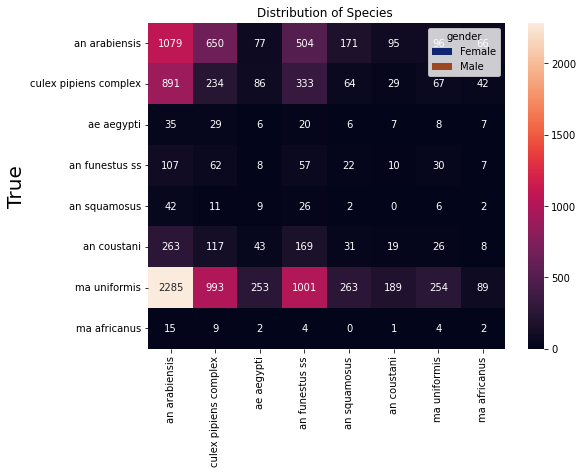

epoch = 1batch = 0 of 4516duraation = 0.0067690809567769366
epoch = 1batch = 1000 of 4516duraation = 5.74113359451294
epoch = 1batch = 2000 of 4516duraation = 11.47496321996053
epoch = 1batch = 3000 of 4516duraation = 17.21004093090693
epoch = 1batch = 4000 of 4516duraation = 22.94503644704819
Epoch: 1, Train Loss: 0.72949403, Train f1: 0.16563110, Val Loss: 0.00147352, Val f1: 0.17400999, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e1_2023_05_17_03_38_38.pth
Now printing classification rport... 
********************************
Current LR = 0.00000420
                       precision    recall  f1-score   support

        an arabiensis       0.39      0.25      0.30      4717
culex pipiens complex       0.12      0.10      0.11      2105
           ae aegypti       0.07      0.02      0.03       484
       an funestus ss       0.20      0.03      0.06      2114
         an squamosus       0.02      0.00      0.01       559
          an coustani       

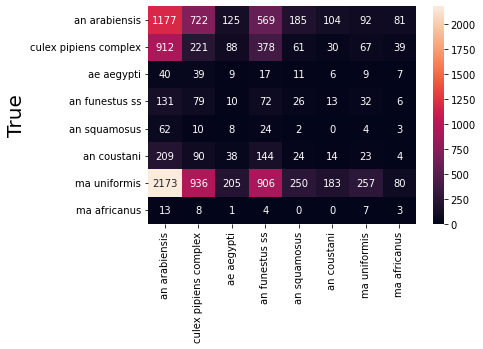

epoch = 2batch = 0 of 4516duraation = 0.00781952937444051
epoch = 2batch = 1000 of 4516duraation = 5.738109119733175
epoch = 2batch = 2000 of 4516duraation = 11.472359816233316
epoch = 2batch = 3000 of 4516duraation = 17.20729091564814
epoch = 2batch = 4000 of 4516duraation = 22.9416343331337
..Overrun....no improvement
Epoch: 2, Train Loss: 0.73342746, Train f1: 0.15966162, Val Loss: 0.00148428, Val f1: 0.15335556, overrun_counter 0
epoch = 3batch = 0 of 4516duraation = 0.006317440668741862
epoch = 3batch = 1000 of 4516duraation = 5.738488892714183
epoch = 3batch = 2000 of 4516duraation = 11.47168177763621
epoch = 3batch = 3000 of 4516duraation = 17.205805321534474
epoch = 3batch = 4000 of 4516duraation = 22.94088447888692
Epoch: 3, Train Loss: 0.72922136, Train f1: 0.16383539, Val Loss: 0.00147159, Val f1: 0.18051070, overrun_counter -1
Saving model to: /dli/task/ComParE2022_VecNet/models/model_e3_2023_05_17_04_35_10.pth
Now printing classification rport... 
*************************

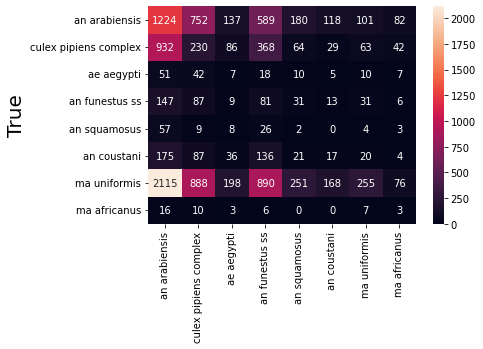

epoch = 4batch = 0 of 4516duraation = 0.006837499141693115
epoch = 4batch = 1000 of 4516duraation = 5.73978351354599
epoch = 4batch = 2000 of 4516duraation = 11.474015156428019
epoch = 4batch = 3000 of 4516duraation = 17.207744773228963
epoch = 4batch = 4000 of 4516duraation = 22.94325877825419
..Overrun....no improvement
Epoch: 4, Train Loss: 0.73128090, Train f1: 0.16194143, Val Loss: 0.00147862, Val f1: 0.16330958, overrun_counter 0
epoch = 5batch = 0 of 4516duraation = 0.005960047245025635
epoch = 5batch = 1000 of 4516duraation = 5.740081779162089
epoch = 5batch = 2000 of 4516duraation = 11.473836529254914
epoch = 5batch = 3000 of 4516duraation = 17.209473061561585
epoch = 5batch = 4000 of 4516duraation = 22.943607020378114
..Overrun....no improvement
Epoch: 5, Train Loss: 0.73645308, Train f1: 0.16170606, Val Loss: 0.00147435, Val f1: 0.17109212, overrun_counter 1
epoch = 6batch = 0 of 4516duraation = 0.0051624059677124025
epoch = 6batch = 1000 of 4516duraation = 5.740858089923859

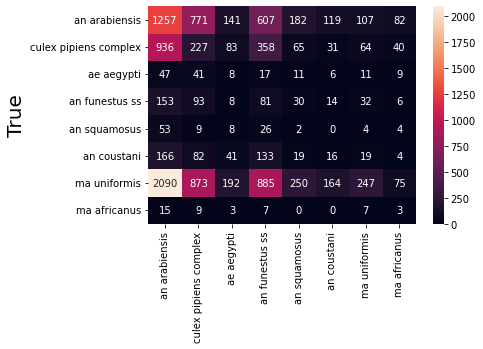

epoch = 9batch = 0 of 4516duraation = 0.006786664326985677
epoch = 9batch = 1000 of 4516duraation = 5.740166819095611
epoch = 9batch = 2000 of 4516duraation = 11.474675861994426
epoch = 9batch = 3000 of 4516duraation = 17.20835177898407
epoch = 9batch = 4000 of 4516duraation = 22.944037878513335
..Overrun....no improvement
Epoch: 9, Train Loss: 0.73131261, Train f1: 0.16083439, Val Loss: 0.00148743, Val f1: 0.14709381, overrun_counter 0
epoch = 10batch = 0 of 4516duraation = 0.007576187451680501
epoch = 10batch = 1000 of 4516duraation = 5.739639441172282
epoch = 10batch = 2000 of 4516duraation = 11.473388636112213
epoch = 10batch = 3000 of 4516duraation = 17.2072052081426
epoch = 10batch = 4000 of 4516duraation = 22.940776642163595
..Overrun....no improvement
Epoch: 10, Train Loss: 0.73156787, Train f1: 0.16161940, Val Loss: 0.00148031, Val f1: 0.15971263, overrun_counter 1
epoch = 11batch = 0 of 4516duraation = 0.006289192040761312
epoch = 11batch = 1000 of 4516duraation = 5.738320962

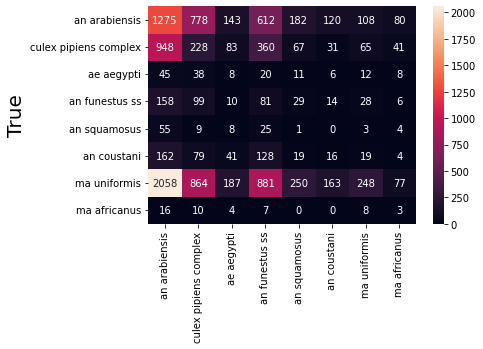

epoch = 16batch = 0 of 4516duraation = 0.006628704071044922
epoch = 16batch = 1000 of 4516duraation = 5.739311027526855
epoch = 16batch = 2000 of 4516duraation = 11.4747376759847
epoch = 16batch = 3000 of 4516duraation = 17.20954085191091
epoch = 16batch = 4000 of 4516duraation = 22.943054707845054
..Overrun....no improvement
Epoch: 16, Train Loss: 0.73482031, Train f1: 0.16080140, Val Loss: 0.00147260, Val f1: 0.17769307, overrun_counter 0
epoch = 17batch = 0 of 4516duraation = 0.006385095914204915
epoch = 17batch = 1000 of 4516duraation = 5.739839744567871
epoch = 17batch = 2000 of 4516duraation = 11.474654738108317
epoch = 17batch = 3000 of 4516duraation = 17.211676732699075
epoch = 17batch = 4000 of 4516duraation = 22.947469917933145
..Overrun....no improvement
Epoch: 17, Train Loss: 0.73193670, Train f1: 0.16279295, Val Loss: 0.00147098, Val f1: 0.18019819, overrun_counter 1
epoch = 18batch = 0 of 4516duraation = 0.005686994393666585
epoch = 18batch = 1000 of 4516duraation = 5.740

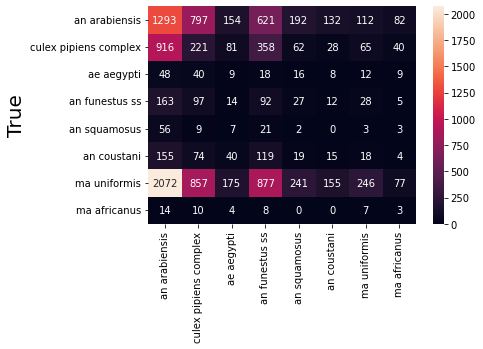

epoch = 19batch = 0 of 4516duraation = 0.007111112276713054
epoch = 19batch = 1000 of 4516duraation = 5.738657689094543
epoch = 19batch = 2000 of 4516duraation = 11.472766268253327
epoch = 19batch = 3000 of 4516duraation = 17.206262441476188
epoch = 19batch = 4000 of 4516duraation = 22.940288186073303
..Overrun....no improvement
Epoch: 19, Train Loss: 0.73085725, Train f1: 0.16161966, Val Loss: 0.00147255, Val f1: 0.17657802, overrun_counter 0
epoch = 20batch = 0 of 4516duraation = 0.008003322283426921
epoch = 20batch = 1000 of 4516duraation = 5.740629581610362
epoch = 20batch = 2000 of 4516duraation = 11.474639383951823
epoch = 20batch = 3000 of 4516duraation = 17.210129380226135
epoch = 20batch = 4000 of 4516duraation = 22.944013567765555
..Overrun....no improvement
Epoch: 20, Train Loss: 0.73025240, Train f1: 0.16568463, Val Loss: 0.00147052, Val f1: 0.18205157, overrun_counter 1
epoch = 21batch = 0 of 4516duraation = 0.007476917902628581
epoch = 21batch = 1000 of 4516duraation = 5.

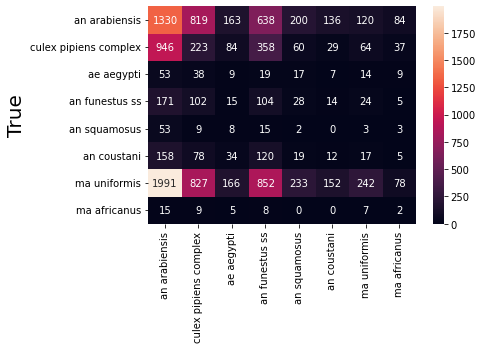

epoch = 22batch = 0 of 4516duraation = 0.007071101665496826
epoch = 22batch = 1000 of 4516duraation = 5.740121221542358
epoch = 22batch = 2000 of 4516duraation = 11.475334088007608
epoch = 22batch = 3000 of 4516duraation = 17.210950346787772
epoch = 22batch = 4000 of 4516duraation = 22.947342280546824
..Overrun....no improvement
Epoch: 22, Train Loss: 0.73098697, Train f1: 0.16290869, Val Loss: 0.00147726, Val f1: 0.16573035, overrun_counter 0
epoch = 23batch = 0 of 4516duraation = 0.006804418563842773
epoch = 23batch = 1000 of 4516duraation = 5.739766863981883
epoch = 23batch = 2000 of 4516duraation = 11.473604198296865
epoch = 23batch = 3000 of 4516duraation = 17.209389897187553
epoch = 23batch = 4000 of 4516duraation = 22.944401745001475
..Overrun....no improvement
Epoch: 23, Train Loss: 0.73026276, Train f1: 0.16533566, Val Loss: 0.00148460, Val f1: 0.15204169, overrun_counter 1
epoch = 24batch = 0 of 4516duraation = 0.006538951396942138
epoch = 24batch = 1000 of 4516duraation = 5.

KeyboardInterrupt: 

In [22]:
csv_loc = os.path.join("..","..","data","metadata","neurips_2021_zenodo_0_0_1.csv")
df = prepare_df(classes = classes,csv_loc = csv_loc)
plot_df(df)
df_train ,df_val ,df_test = train_test_split(df)
print("now validating the split post loading and keeping TZ data")
validate_split(df_train ,df_val)
validate_split(df_train ,df_test)
validate_split(df_test ,df_val)
df_train_offset = get_offsets_df(df_train, short_audio=True)
df_test_offset = get_offsets_df(df_test, short_audio=True)
df_val_offset = get_offsets_df(df_val, short_audio=True)
df_train_offset.reset_index(inplace = True , drop = True)
df_test_offset.reset_index(inplace = True , drop = True)
df_val_offset.reset_index(inplace = True , drop = True)
print("now validating the split post offset_creation")
validate_split(df_train_offset ,df_val_offset)
validate_split(df_train_offset ,df_test_offset)
validate_split(df_test_offset ,df_val_offset)

class_weights = get_class_weights(df_train_offset)
print("inside main. class_weigths type = ", type(class_weights))
model =MyModel('convnext_xlarge_in22k',224)
min_length = (config.win_size * config.n_hop) / config.rate

train_dataset = MozDataset(df_train_offset,  config.data_dir, min_length)
val_dataset = MozDataset(df_val_offset,  config.data_dir, min_length)
test_dataset = MozDataset(df_test_offset,  config.data_dir, min_length)

train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=num_workers,batch_size = batch_size,shuffle = True, pin_memory=True )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory, shuffle = True )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers= num_workers, pin_memory=pin_memory,shuffle = True)

encoder = SupConResNet()

#train_loader, val_loader,test_loader, model ,class_weights, classes = classes, num_epochs = num_epochs ,n_channels = 1
#train_loader, val_loader,test_loader, model, classes ,df,num_epochs = num_epochs ,n_channels = 1
tr_model, lr_log,all_train_f1,all_train_loss,all_val_loss,all_val_f1 = train_model(train_loader, val_loader, test_loader,model,classes,class_weights ,num_epochs,encoder )

print("ALL DONE!!!!")




